In [359]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import pyarrow

file = pd.read_csv("Bitfinex_BTCEUR_trades_2018_02_02.csv")
file.head()



,id,exchange,symbol,date,price,amount,sell
0,183601815,bf,btceur,1517529608000,7349.60000,0.004568,False
1,183601825,bf,btceur,1517529609000,7354.68045,0.010000,True
2,183601823,bf,btceur,1517529609000,7354.68045,0.004568,True
3,183601833,bf,btceur,1517529610000,7354.60000,0.102395,False
4,183601904,bf,btceur,1517529626000,7343.40750,0.086580,False


In [360]:
from datetime import datetime
import pandas as pd
import os
import fastparquet 

def convert_dates(date):
    """
    Converts time since the Unix epoch in milliseconds to a datetime object.
    """
    return datetime.fromtimestamp(date / 1000)


In [361]:
def read_trade_data(file):
    """
    Read csv containing crypto trade data at <filepath>, convert time fields
    and select relevant columns.

    :param filepath: path to csv file
    :returns: (exchange, symbol, preprocessed Pandas dataframe)
    """
    trades = pd.read_csv("Bitfinex_BTCEUR_trades_2018_02_02.csv")
    # convert dates from unix timestamps
    trades['date'] = trades['date'].apply(convert_dates)
    trades.set_index('date', inplace=True)
    trades.sort_index(ascending=True, inplace=True)
    # check data relates to a single exchange and coin pair
    assert trades['exchange'].nunique() == 1, 'Multiple exchanges present'
    assert trades['symbol'].nunique() == 1, 'Multiple symbols present'
    # select relevant columns
    trade_features = trades[['price', 'amount', 'sell']]
    exchange = trades['exchange'].iloc[0]
    symbol = trades['symbol'].iloc[0]
    return exchange, symbol, trade_features



In [362]:
def write_processed(exchange, symbol, data, loc=None):
    """
    Write processed features for a given exchange and coin pair
    to a parquet file named '<exchange>_<symbol>_trades.parquet'.

    :param exchange: str exchange name
    :param symbol: str symbol name
    :param data: dataframe
    :param loc: alternative filepath in which to save
    """
    filename = f'{exchange}_{symbol}_trades.parquet'
    path = os.getcwd() if loc is None else loc
    filepath = os.path.join(path, filename)
    data.to_parquet(file)


    if __name__ == "__main__":
        exchange, symbol, data = read_trade_data('Bitfinex_BTCEUR_trades_'
                                             '2018_02_02.csv')

        write_processed(exchange, symbol, data)

from fastparquet import ParquetFile
pf = ParquetFile('bf_btceur_trades.parquet')
df = pf.to_pandas()

pf = pd.read_parquet('bf_btceur_trades.parquet')
pf.dropna()
pf.reset_index(inplace = True)
pf.head()
dates = pf.set_index(['date'], ['price'])
dates.head()


 

,price,amount,sell
date,,,
2018-02-02 02:00:08,7349.60000,0.004568,False
2018-02-02 02:00:09,7354.68045,0.010000,True
2018-02-02 02:00:09,7354.68045,0.004568,True
2018-02-02 02:00:10,7354.60000,0.102395,False
2018-02-02 02:00:26,7343.40750,0.086580,False


In [363]:
#simple moving average
MA_WINDOW = 10
dates['SMA-10'] = dates['price'].rolling(window=MA_WINDOW).mean()
dates.head()
dates.tail()

,price,amount,sell,SMA-10
date,,,,
2018-02-03 01:58:58,7123.500000,0.10000,True,7139.250000
2018-02-03 01:59:17,7128.172061,0.03050,True,7138.037206
2018-02-03 01:59:22,7134.433152,0.02444,False,7137.380521
2018-02-03 01:59:33,7136.199101,0.01000,True,7136.480431
2018-02-03 01:59:33,7136.200000,0.00603,True,7134.990431


In [364]:
MA_WINDOW = 100
dates['SMA-100'] = dates['price'].rolling(window=MA_WINDOW).mean()
dates.head()
dates.tail()

,price,amount,sell,SMA-10,SMA-100
date,,,,,
2018-02-03 01:58:58,7123.500000,0.10000,True,7139.250000,7109.745258
2018-02-03 01:59:17,7128.172061,0.03050,True,7138.037206,7109.866979
2018-02-03 01:59:22,7134.433152,0.02444,False,7137.380521,7110.111311
2018-02-03 01:59:33,7136.199101,0.01000,True,7136.480431,7110.263302
2018-02-03 01:59:33,7136.200000,0.00603,True,7134.990431,7110.537302


Text(0.5,1,'SIMPLE MOVING AVG WINDOW = 10')

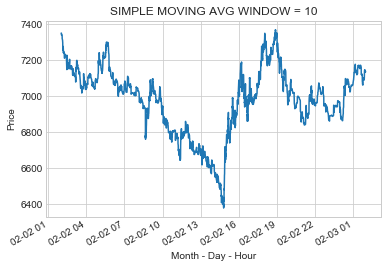

In [365]:
#simple moving average visualization 
import numpy as np
import seaborn as sns 
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()
x = dates.index.values
y = dates['SMA-10']

plt.plot(x, y)
plt.xlabel("Month - Day - Hour")
plt.ylabel("Price")
plt.gcf().autofmt_xdate()
plt.title("SIMPLE MOVING AVG WINDOW = 10")

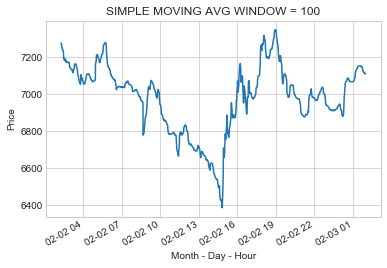

In [366]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()
x = dates.index.values
y = dates['SMA-100']
plt.title("SIMPLE MOVING AVG WINDOW = 100")

plt.plot(x, y)
plt.xlabel("Month - Day - Hour")
plt.ylabel("Price")
plt.gcf().autofmt_xdate()

In [367]:
pf = pd.read_parquet('bf_btceur_trades.parquet')
pf.dropna()
pf.reset_index(inplace = True)
pf.head()
dates = pf.set_index(['date'], ['price'])



In [368]:
pf.head()


,date,price,amount,sell
0,2018-02-02 02:00:08,7349.60000,0.004568,False
1,2018-02-02 02:00:09,7354.68045,0.010000,True
2,2018-02-02 02:00:09,7354.68045,0.004568,True
3,2018-02-02 02:00:10,7354.60000,0.102395,False
4,2018-02-02 02:00:26,7343.40750,0.086580,False


No handles with labels found to put in legend.


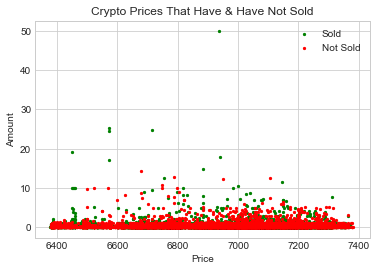

In [369]:
true_pf = pf[pf['sell']== True]
false_pf = pf[pf['sell']== False]
x_var_true = true_pf['price']
x_var_false = false_pf['price']
x = pf['price']
y_var_true = true_pf['amount']
y_var_false = false_pf['amount']
z = pf['sell']
# c=condition
plt.legend()
plt.xlabel('Price')
plt.ylabel('Amount')
plt.title("Crypto Prices That Have & Have Not Sold")
#condition = np.where(z!=True, 'red', np.where(z!=False, 'green', 'r'))
plt.scatter(x_var_true, y_var_true, s=5, c = 'g', label = 'Sold')
plt.scatter(x_var_false, y_var_false, s=5, c = 'r', label = 'Not Sold')
plt.legend()